In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers , regularizers
from tensorflow.keras.utils import plot_model

In [29]:
DATA_ROOT = Path(r"C:\Users\USER\OneDrive\Desktop\Model\converted_data_run")
TARGET_SHAPE = (66, 200, 3) 
MAX_EXTREME_SAMPLES = 150    
BATCH_SIZE = 32         
EPOCHS = 20

In [3]:
def load_data():
    """Load all CSV files without modification"""
    dfs = []
    for run_dir in DATA_ROOT.glob("run_*"):
        csv_file = run_dir / f"{run_dir.name}.csv"
        if csv_file.exists():
            dfs.append(pd.read_csv(csv_file))
    return pd.concat(dfs, ignore_index=True)

original_df = load_data()

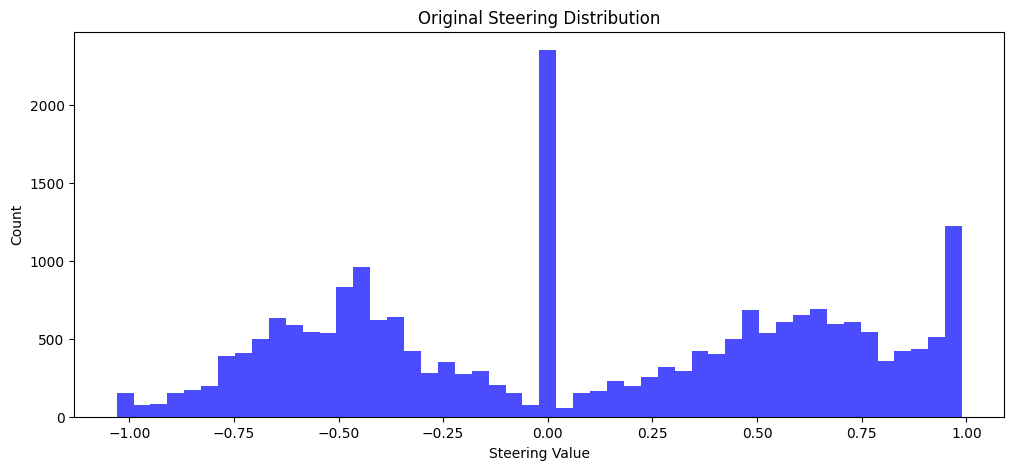

In [4]:
# Visualize initial distribution
plt.figure(figsize=(12,5))
plt.hist(original_df['steering'], bins=50, color='blue', alpha=0.7)
plt.title('Original Steering Distribution')
plt.xlabel('Steering Value')
plt.ylabel('Count')
plt.show()

In [5]:
### 3. Data Balancing (Targeted +1.0 Reduction)
def balance_extreme_values(df, threshold=0.97, max_samples=MAX_EXTREME_SAMPLES):
    """Reduce excessive +1.0 samples while preserving others"""
    extreme_mask = df['steering'] >= threshold
    extreme_df = df[extreme_mask]
    normal_df = df[~extreme_mask]
    
    # Cap extreme samples
    capped_extreme = extreme_df.sample(min(len(extreme_df), max_samples))
    return pd.concat([capped_extreme, normal_df])

balanced_df = balance_extreme_values(original_df)

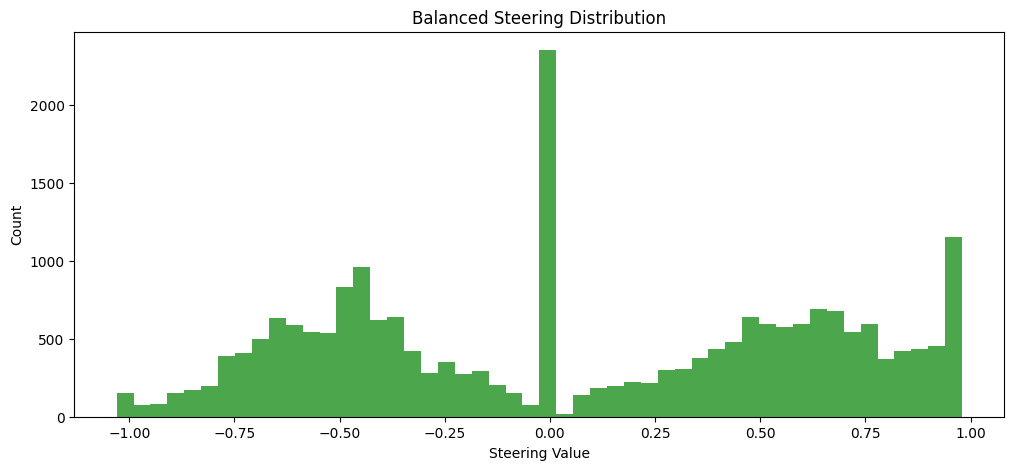

In [7]:
# Visualize balanced data
plt.figure(figsize=(12,5))
plt.hist(balanced_df['steering'], bins=50, color='green', alpha=0.7)
plt.title('Balanced Steering Distribution')
plt.xlabel('Steering Value')
plt.ylabel('Count')
plt.show()

In [8]:
def get_steering_details(dataset, steering_column='steering'):
    """
    Analyzes the dataset and provides details for steering values within specified ranges.

    Args:
        dataset (pd.DataFrame): The dataset containing steering angle information.
        steering_column (str): The name of the column containing steering angles (default: 'steering').

    Returns:
        dict: Dictionary with counts and percentages for each steering range.
    """
    # Ensure the column exists
    if steering_column not in dataset.columns:
        raise ValueError(f"Column '{steering_column}' not found in the dataset.")

    # Define ranges
    ranges = {
        "around_0": (-0.01, 0.01),
        "negative_range": (-1, 0),
        "positive_range": (0, 1)
    }

    # Calculate counts and percentages
    total_count = len(dataset)
    details = {}

    for range_name, (low, high) in ranges.items():
        count = dataset[(dataset[steering_column] >= low) & (dataset[steering_column] <= high)].shape[0]
        percentage = (count / total_count) * 100 if total_count > 0 else 0
        details[range_name] = {
            "count": count,
            "percentage": percentage
        }

    return details

get_steering_details(balanced_df)

{'around_0': {'count': 2349, 'percentage': 10.442320515670149},
 'negative_range': {'count': 11869, 'percentage': 52.762836185819076},
 'positive_range': {'count': 12955, 'percentage': 57.59057568348523}}

In [10]:
def augment_image(image, steering):
    # 1. Random Translation
    rows, cols, _ = image.shape
    tx = np.random.uniform(-40, 40)  # +/- 40 pixels
    ty = np.random.uniform(-10, 10)  # +/- 10 pixels
    steering += tx * 0.002  # Adjust steering based on translation
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (cols, rows))
    
    # 2. Random Zoom
    zoom = np.random.uniform(1, 1.2)
    if zoom > 1:
        h, w = image.shape[:2]
        nh, nw = int(h / zoom), int(w / zoom)
        y1 = (h - nh) // 2
        x1 = (w - nw) // 2
        image = image[y1:y1+nh, x1:x1+nw]
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)

    # 3. Random Brightness
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.random.uniform(0.5, 1.5)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness, 0, 255)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    # 4. Random Flip
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
        steering = -steering  # Reverse steering

    return image, steering

In [11]:
def preprocess_image(image_path, target_shape=(66, 200)):
    """
    Optimized preprocessing pipeline for self-driving car images.
    Args:
        image_path (str): Path to the image file.
        target_shape (tuple): (height, width) for resizing.
    Returns:
        np.ndarray: Preprocessed image, shape (target_shape[0], target_shape[1], 3), normalized to [-1, 1].
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Crop: remove sky and hood (adjust indices as needed for your camera)
    image = image[60:-25, :, :]

    # Convert color space (BGR to YUV)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # Resize
    image = cv2.resize(image, (target_shape[1], target_shape[0]))

    # Gaussian blur (optional, denoise)
    image = cv2.GaussianBlur(image, (3, 3), 0)

    # Normalize to [-1, 1]
    image = image.astype(np.float32) / 127.5 - 1.0

    return image

In [17]:
def data_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            images = []
            for img_path in batch_paths:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Unable to load image at {img_path}")
                    continue
                img = cv2.resize(img, (200, 66))  # Resize to (200, 66)
                img = img / 127.5 - 1.0          # Normalize to [-1, 1]
                images.append(img)

            X = np.array(images)
            y = np.array(batch_labels).reshape(-1, 1)  # Ensure shape (batch_size, 1)


            yield X, y

In [21]:
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42, shuffle=True)

# Extract paths and labels (assuming columns are 'image_path', 'steering')
train_image_paths = train_df['image_path'].tolist()
train_labels = train_df[['steering']].values

val_image_paths = val_df['image_path'].tolist()
val_labels = val_df[['steering']].values

# Assuming you have preprocessed `train_images` and `train_labels`
train_gen = data_generator(train_image_paths, train_labels, batch_size=32)

# Similarly, for validation data
val_gen = data_generator(val_image_paths, val_labels, batch_size=32)


In [22]:
def create_pi_model(input_shape=(66, 200, 3), dropout_rate=0.3, base_filters=16):
    """
    Creates an optimized model for self-driving car tasks inspired by NVIDIA PilotNet.

    Args:
        input_shape (tuple): Shape of the input images (default: (66, 200, 3)).
        dropout_rate (float): Dropout rate for regularization (default: 0.3).
        base_filters (int): Number of filters in the first convolutional layer (default: 16).

    Returns:
        tf.keras.Model: Compiled Keras model.
    """
    model = models.Sequential([
        # Dynamic normalization layer
        layers.Normalization(axis=-1, input_shape=input_shape),

        # Convolutional block 1
        layers.Conv2D(base_filters, (5, 5), strides=(2, 2), activation='relu', padding='valid'),
        layers.BatchNormalization(),

        # Convolutional block 2
        layers.Conv2D(base_filters * 2, (5, 5), strides=(2, 2), activation='relu', padding='valid'),
        layers.BatchNormalization(),

        # Convolutional block 3
        layers.Conv2D(base_filters * 4, (3, 3), strides=(2, 2), activation='relu', padding='valid'),
        layers.BatchNormalization(),

        # Convolutional block 4
        layers.Conv2D(base_filters * 8, (3, 3), strides=(1, 1), activation='relu', padding='valid'),
        layers.BatchNormalization(),

        # Global Average Pooling instead of Flatten
        layers.GlobalAveragePooling2D(),

        # Fully connected layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1)  # Output layer for steering angle
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='mse',
        metrics=['mae']
    )

    return model

# Instantiate the model
model = create_pi_model()

# Print the summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 66, 200, 3)        7         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 98, 16)        1216      
_________________________________________________________________
batch_normalization_8 (Batch (None, 31, 98, 16)        64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 47, 32)        12832     
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 47, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 23, 64)         18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 6, 23, 64)        

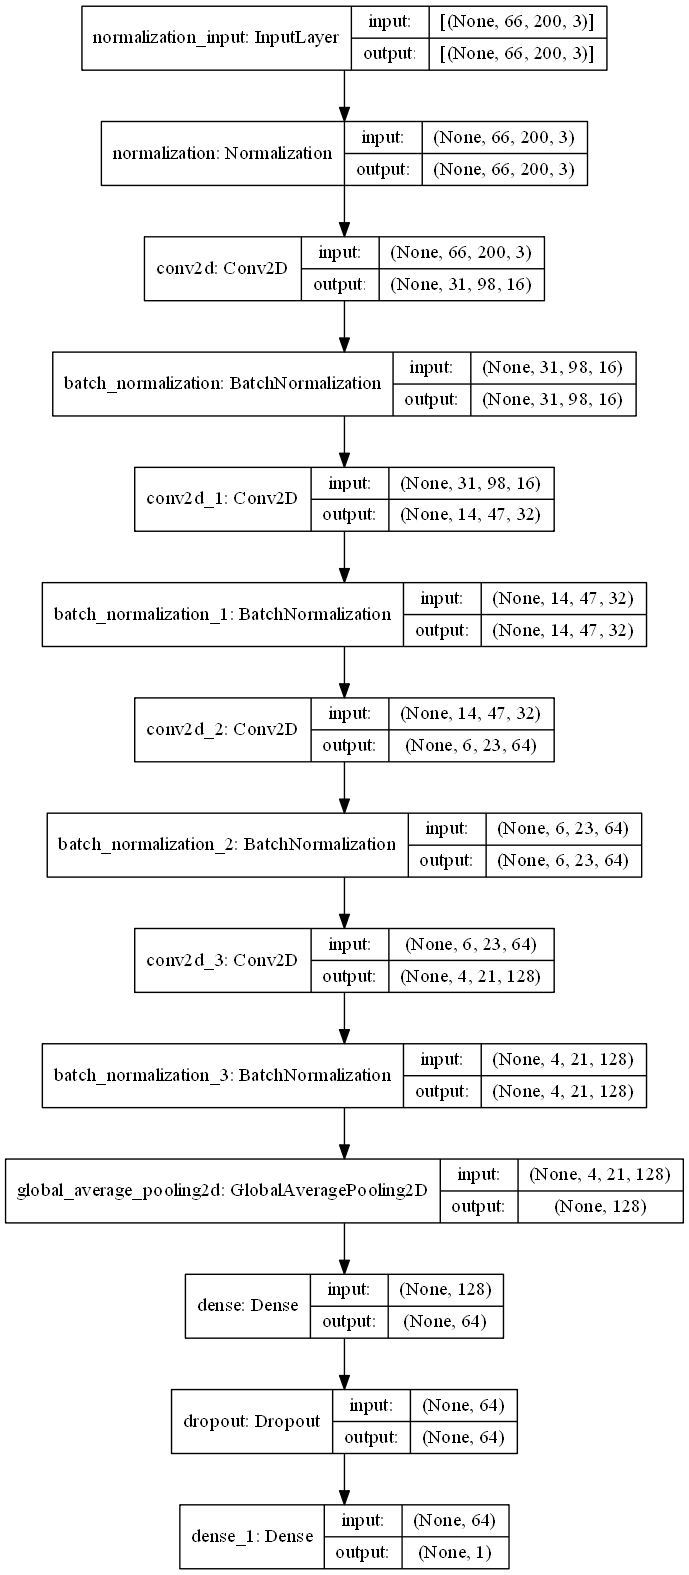

In [15]:
plot_model(
    model,
    to_file="pi_model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=100
)

In [33]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('04__model.h5', save_best_only=True)
    
]

# Training the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
281/281 [==============================] - 45s 160ms/step - loss: 0.0368 - mae: 0.1484 - val_loss: 0.0347 - val_mae: 0.1400
Epoch 2/20
281/281 [==============================] - 45s 160ms/step - loss: 0.0370 - mae: 0.1489 - val_loss: 0.0406 - val_mae: 0.1521
Epoch 3/20
281/281 [==============================] - 48s 171ms/step - loss: 0.0358 - mae: 0.1457 - val_loss: 0.0335 - val_mae: 0.1371
Epoch 4/20
281/281 [==============================] - 44s 156ms/step - loss: 0.0357 - mae: 0.1460 - val_loss: 0.0392 - val_mae: 0.1495
Epoch 5/20
281/281 [==============================] - 44s 156ms/step - loss: 0.0360 - mae: 0.1466 - val_loss: 0.0335 - val_mae: 0.1369
Epoch 6/20
281/281 [==============================] - 44s 156ms/step - loss: 0.0344 - mae: 0.1434 - val_loss: 0.0364 - val_mae: 0.1431
Epoch 7/20
281/281 [==============================] - 43s 154ms/step - loss: 0.0349 - mae: 0.1443 - val_loss: 0.0337 - val_mae: 0.1375
Epoch 8/20
281/281 [==============================] - 4

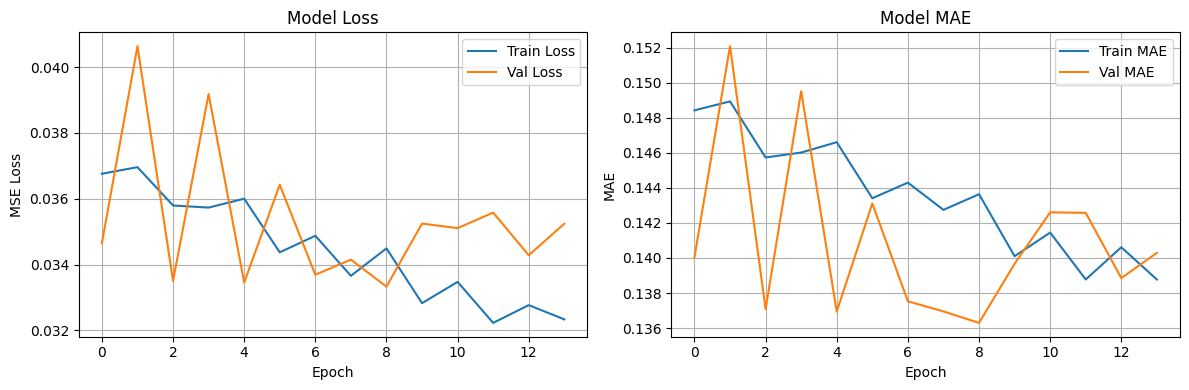

In [46]:
def plot_learning_curves(history):
    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    # plt.savefig("04_loss_plot.png")
    plt.show()

    

plot_learning_curves(history)

# Usage:
# plot_learning_curves(history)

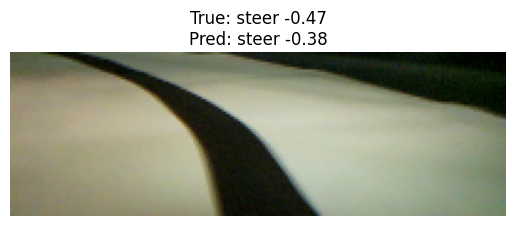

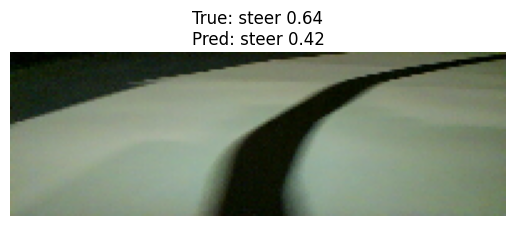

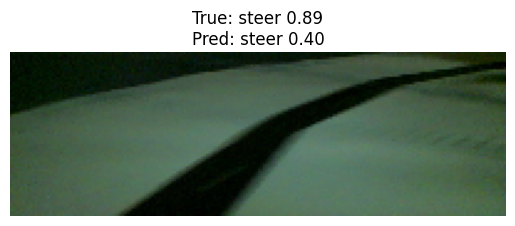

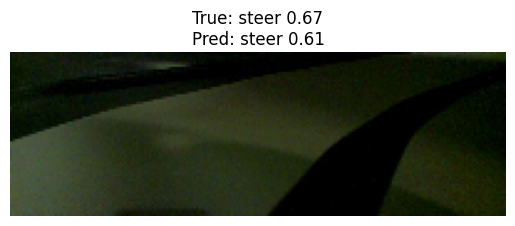

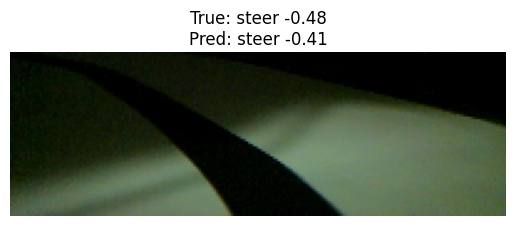

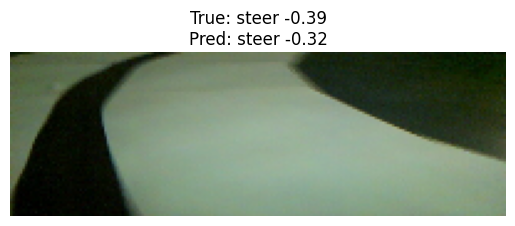

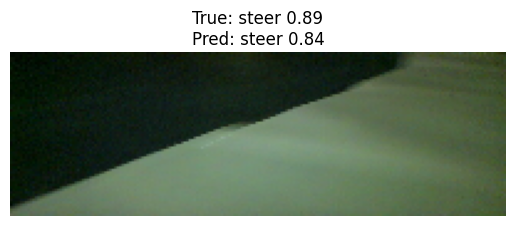

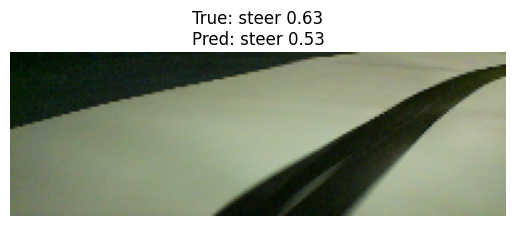

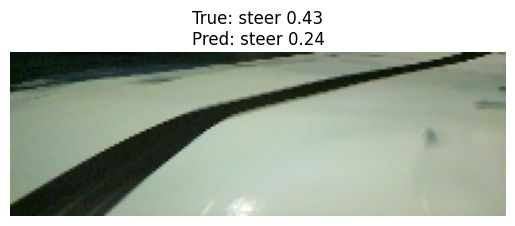

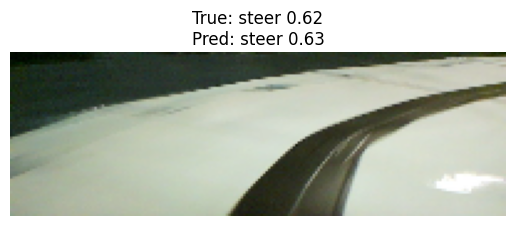

In [43]:
def visualize_predictions(model, val_gen, num_batches=2):
    for batch_num in range(num_batches):
        images, y_true = next(val_gen)
        y_pred = model.predict(images)
        for i in range(min(5, len(images))):  # Show up to 5 images per batch
            img = images[i]
            # Undo normalization for display if needed
            img_display = ((img + 1) * 127.5).astype(np.uint8) if np.max(img) <= 1 else img.astype(np.uint8)
            plt.imshow(img_display)
            plt.axis('off')
            plt.title(
                f"True: steer {y_true[i,0]:.2f}\n"
                f"Pred: steer {y_pred[i,0]:.2f}"
            )
            plt.savefig("04_test.png")
            plt.show()
            
visualize_predictions(model, val_gen)

In [39]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('04_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp1z4_olrw\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp1z4_olrw\assets
